In [1]:
# import module
import io
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

np.random.seed(42)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv("mbti_1.csv")

In [4]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'E':0, 'I':1, 'S':0, 'N':1, 'T':0, 'F':1, 'J':0, 'P':1}
b_Pers_list = [{0:'E', 1:'I'}, {0:'S', 1:'N'}, {0:'T', 1:'F'}, {0:'J', 1:'P'}]

#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])

In [5]:
#print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 1 0]
 [0 1 0 1]
 [1 1 0 1]
 ...
 [1 1 0 1]
 [1 1 1 1]
 [1 1 1 1]]


In [6]:
data['E-I'] = list_personality_bin[:,0]
data['S-N'] = list_personality_bin[:,1]
data['T-F'] = list_personality_bin[:,2]
data['J-P'] = list_personality_bin[:,3]

In [7]:
#data.head()

,type,posts,E-I,S-N,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0


## 데이터전처리

In [8]:
from sklearn.preprocessing import LabelBinarizer
import re
import string

In [9]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'I\'m', 'I am'),(r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replace(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

text_replace = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_replace['TextBefore'] = data['posts'].copy()

In [10]:
for index, row in text_replace.iterrows():
    row['TextAfter'] = replace(row['TextBefore'])

In [12]:
#print(text_replace['TextBefore'][:5],'\n->\n', text_replace['TextAfter'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: TextBefore, dtype: object 
->
 0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object


## 특수문자 제거

In [13]:
def cleaner(post):
    # 소문자 변환
    post = post.lower() 
    
    # '|||' 제거
    post = post.replace('|||', "") 

    # URL, 링크 등 특수문자 제거
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 

    # 구두점 제거
    post = post.translate(str.maketrans('', '', string.punctuation))

    # 공백 제거
    post = re.sub( '\s+', ' ', post ).strip()

    # MBTI 제거
    post = re.sub('infj|entp|intp|intj|entj|enfj|infp|enfp|isfp|istp|isfj|istj|estp|esfp|estj|esfj',"", post)

    # 길이가 짧은 단어 제거
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    post = shortword.sub('', post)
    
    return post

In [14]:
posts = text_replace.TextAfter.tolist()
posts = [cleaner(post) for post in posts]
data['clean_post'] = posts

In [15]:
#print(text_replace['TextAfter'][:5],'\n->\n', data['clean_post'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object 
->
 0    and  moments sportscenter not top ten plays pr...
1     finding the lack these posts very alarmingsex...
2    good one course which say know that blessing a...
3    dear enjoyed our conversation the other day es...
4    you are firedthat another silly misconception ...
Name: clean_post, dtype: object


## remove stopwords

In [16]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')

from nltk.stem import WordNetLemmatizer, PorterStemmer

n=WordNetLemmatizer()
s = PorterStemmer()

def tokenize(text):
    finalTokens = []
    tokens = nltk.word_tokenize(text)
    for w in tokens:
        if (w not in stoplist):
            finalTokens.append(w)
    lem  = [n.lemmatize(w) for w in finalTokens]
    stem = [s.stem(w) for w in lem]
    text = " ".join(stem)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skdld\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\skdld\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
text_removeStopwords = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_removeStopwords['TextBefore'] = data['clean_post'].copy()

In [18]:
nltk.download('punkt')
for index, row in text_removeStopwords.iterrows():
    row['TextAfter'] = tokenize(row['TextBefore'])

data['clean_post'] = text_removeStopwords['TextAfter']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skdld\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
#print(data['clean_post'][:5],'\n->\n',text_removeStopwords['TextAfter'][:5])

0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object 
->
 0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: TextAfter, dtype: object


## Most frequent mispells -> Correct manually

In [20]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [21]:
data['clean_post'] = data['clean_post'].apply(lambda x: correct_spelling(x, mispell_dict))
#data['clean_post'][:5]

0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object

## Train/ Test/ Validation data Split
계층적으로 분리

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data[['type']]):
    train = data.loc[train_index]
    test = data.loc[test_index]

In [42]:
train.head(2)

,type,posts,E-I,S-N,T-F,J-P,clean_post
1228,INFP,'We are mandarin speakers. He receive educati...,1,1,1,1,mandarin speaker receiv educ canada sinc 13tha...
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ...",1,0,0,1,nope ever busi work caus adrenalinerush activ ...


In [43]:
test.head(2)

,type,posts,E-I,S-N,T-F,J-P,clean_post
7814,INFP,"'Macona , it depends if the big family has ext...",1,1,1,1,macona depend big famili extrovert peopl every...
4635,ENFJ,'My Brother is an ISTP and oddly enough I get ...,0,1,1,0,brother oddli enough get along better peopl fa...


In [46]:
list_personality_bin_train = np.array([translate_personality(p) for p in train.type])

In [47]:
list_personality_bin_test = np.array([translate_personality(p) for p in test.type])

In [48]:
X_train = train.clean_post
X_test = test.clean_post
y_train = list_personality_bin_train
y_test = list_personality_bin_test

## 모델 훈련

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve

In [51]:
categories = ['E-I', 'S-N', 'T-F', 'J-P']

... Processing E-I
0.7695965417867435 0.7694524495677233
f1_score is 0.8697068403908794
[[   0  400]
 [   0 1335]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.77      1.00      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.38      0.50      0.43      1735
weighted avg       0.59      0.77      0.67      1735

... Processing S-N


C:\Users\skdld\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8619596541786744 0.8622478386167147
f1_score is 0.9260290931600124
[[   0  239]
 [   0 1496]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.86      1.00      0.93      1496

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.80      1735

... Processing T-F


C:\Users\skdld\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7750720461095101 0.7198847262247838
f1_score is 0.7786885245901639
[[394 402]
 [ 84 855]]
              precision    recall  f1-score   support

           0       0.82      0.49      0.62       796
           1       0.68      0.91      0.78       939

    accuracy                           0.72      1735
   macro avg       0.75      0.70      0.70      1735
weighted avg       0.75      0.72      0.71      1735

... Processing J-P
0.6046109510086455 0.6040345821325649
f1_score is 0.7531440891124686
[[   0  686]
 [   1 1048]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       686
           1       0.60      1.00      0.75      1049

    accuracy                           0.60      1735
   macro avg       0.30      0.50      0.38      1735
weighted avg       0.37      0.60      0.46      1735



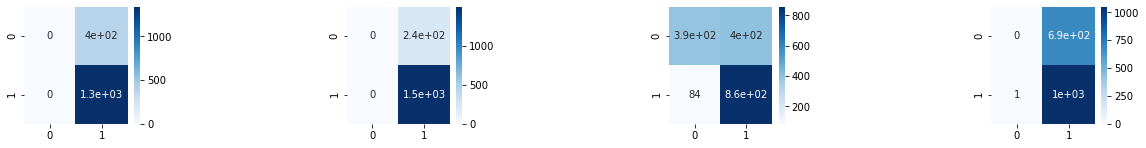

Average f1-score of LinearSVC :  0.8318921368133811


In [52]:
import seaborn as sns
from matplotlib import gridspec
from sklearn.model_selection import StratifiedKFold

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(C=0.01), n_jobs=1))
])

total_f1_score = 0

fig = plt.figure(figsize=(18, 16)) 
gs = gridspec.GridSpec(8,8 ) 
n=0

for category in categories:
    print('... Processing {}'.format(category))

    model = SVC_pipeline.fit(X_train, train[category])
    prediction = model.predict(X_test)
    scoreTrain = model.score(X_train, train[category])
    scoreTest = model.score(X_test, test[category])
    print(scoreTrain, scoreTest)

    f1_score_ = f1_score(test[category], prediction)
    total_f1_score += f1_score_
    print('f1_score is {}'.format(f1_score_))

    cf_matrix = confusion_matrix(test[category], prediction)
    print(cf_matrix)
    print(classification_report(test[category], prediction))

    # labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    # labels = np.asarray(labels).reshape(2,2)
    plt.subplot(gs[n*2+0])
    sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    n+=1
    # fpr, tpr, thresholds = roc_curve(train[category], SVC_pipeline.predict_proba(X_train)[:, 1])
    # plt.plot(fpr, tpr, '-', label=category)

# plt.plot([0, 1], [0, 1], 'k--', label="random guess")
# plt.legend(fontsize = 8)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('MultinomialNB ROC Curve')
# plt.show()

plt.tight_layout()  # 창 크기에 맞게 조정
plt.show()
print('Average f1-score of LinearSVC : ', total_f1_score/4)
# print('Average precision of LinearSVC : ', total_precision/4)
# print('Average recall of LinearSVC : ', total_recall/4)

In [53]:
SVC_pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=0.01), n_jobs=1))])

In [55]:
import pickle
pickle.dump(SVC_pipeline, open('mbti.pkl', 'wb'))